In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00005
num_epochs = 25

In [3]:
#CREATE DATASET

dataset = torch.load("cps_unet_dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

model = Unet(
    encoder_name="resnet34",
    in_channels=16,
    classes=1,
    activation=None
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [6]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader):
    model.train()
    train_loss = 0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        all_preds.append(outputs.detach().cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    avg_loss = train_loss / len(train_loader)

    y_true = np.concatenate(all_labels).ravel()
    y_pred = np.concatenate(all_preds).ravel()
    r2 = r2_score(y_true, y_pred)

    return avg_loss, r2


def eval(model, val_loader):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_loss = val_loss / len(val_loader)
    y_true = np.concatenate(all_labels).ravel()
    y_pred = np.concatenate(all_preds).ravel()
    r2 = r2_score(y_true, y_pred)

    return avg_loss, r2


In [7]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = eval(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch: {e} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

100%|██████████| 94/94 [00:19<00:00,  4.72it/s]


Epoch: 1 | Train Loss: 202.3719 | Train Acc: -0.7984 | Val Loss: 204.6903 | Val Acc: -0.8032


100%|██████████| 94/94 [00:11<00:00,  8.09it/s]


Epoch: 2 | Train Loss: 185.6677 | Train Acc: -0.6495 | Val Loss: 181.7029 | Val Acc: -0.6007


100%|██████████| 94/94 [00:11<00:00,  8.10it/s]


Epoch: 3 | Train Loss: 172.7973 | Train Acc: -0.5354 | Val Loss: 187.5593 | Val Acc: -0.6521


100%|██████████| 94/94 [00:11<00:00,  7.91it/s]


Epoch: 4 | Train Loss: 161.8463 | Train Acc: -0.4379 | Val Loss: 171.8047 | Val Acc: -0.5134


100%|██████████| 94/94 [00:11<00:00,  7.93it/s]


Epoch: 5 | Train Loss: 152.4354 | Train Acc: -0.3542 | Val Loss: 153.0356 | Val Acc: -0.3480


100%|██████████| 94/94 [00:11<00:00,  8.04it/s]


Epoch: 6 | Train Loss: 143.7479 | Train Acc: -0.2777 | Val Loss: 125.2896 | Val Acc: -0.1035


100%|██████████| 94/94 [00:11<00:00,  8.09it/s]


Epoch: 7 | Train Loss: 135.3070 | Train Acc: -0.2023 | Val Loss: 167.7601 | Val Acc: -0.4778


100%|██████████| 94/94 [00:11<00:00,  7.91it/s]


Epoch: 8 | Train Loss: 126.9593 | Train Acc: -0.1281 | Val Loss: 122.1222 | Val Acc: -0.0763


100%|██████████| 94/94 [00:11<00:00,  7.99it/s]


Epoch: 9 | Train Loss: 118.4459 | Train Acc: -0.0528 | Val Loss: 145.9099 | Val Acc: -0.2856


100%|██████████| 94/94 [00:11<00:00,  7.88it/s]


Epoch: 10 | Train Loss: 110.3514 | Train Acc: 0.0194 | Val Loss: 170.2892 | Val Acc: -0.5004


100%|██████████| 94/94 [00:11<00:00,  8.11it/s]


Epoch: 11 | Train Loss: 102.2981 | Train Acc: 0.0911 | Val Loss: 82.5523 | Val Acc: 0.2736


100%|██████████| 94/94 [00:11<00:00,  7.91it/s]


Epoch: 12 | Train Loss: 95.9166 | Train Acc: 0.1472 | Val Loss: 103.1914 | Val Acc: 0.0907


100%|██████████| 94/94 [00:11<00:00,  7.98it/s]


Epoch: 13 | Train Loss: 89.7712 | Train Acc: 0.2021 | Val Loss: 140.8910 | Val Acc: -0.2408


100%|██████████| 94/94 [00:11<00:00,  8.04it/s]


Epoch: 14 | Train Loss: 84.2714 | Train Acc: 0.2510 | Val Loss: 99.7368 | Val Acc: 0.1224


100%|██████████| 94/94 [00:11<00:00,  8.09it/s]


Epoch: 15 | Train Loss: 79.5134 | Train Acc: 0.2938 | Val Loss: 115.1281 | Val Acc: -0.0142


100%|██████████| 94/94 [00:11<00:00,  7.94it/s]


Epoch: 16 | Train Loss: 74.4701 | Train Acc: 0.3380 | Val Loss: 104.8872 | Val Acc: 0.0764


100%|██████████| 94/94 [00:11<00:00,  7.88it/s]


Epoch: 17 | Train Loss: 70.1457 | Train Acc: 0.3766 | Val Loss: 86.8422 | Val Acc: 0.2349


100%|██████████| 94/94 [00:11<00:00,  7.98it/s]


Epoch: 18 | Train Loss: 65.9836 | Train Acc: 0.4135 | Val Loss: 81.8474 | Val Acc: 0.2791


100%|██████████| 94/94 [00:12<00:00,  7.80it/s]


Epoch: 19 | Train Loss: 62.0605 | Train Acc: 0.4484 | Val Loss: 70.2668 | Val Acc: 0.3817


100%|██████████| 94/94 [00:11<00:00,  7.85it/s]


Epoch: 20 | Train Loss: 58.8628 | Train Acc: 0.4768 | Val Loss: 75.4319 | Val Acc: 0.3355


100%|██████████| 94/94 [00:11<00:00,  7.85it/s]


Epoch: 21 | Train Loss: 55.8475 | Train Acc: 0.5036 | Val Loss: 63.6691 | Val Acc: 0.4393


100%|██████████| 94/94 [00:11<00:00,  7.90it/s]


Epoch: 22 | Train Loss: 53.2264 | Train Acc: 0.5272 | Val Loss: 70.3550 | Val Acc: 0.3804


100%|██████████| 94/94 [00:11<00:00,  7.96it/s]


Epoch: 23 | Train Loss: 50.7197 | Train Acc: 0.5495 | Val Loss: 60.8423 | Val Acc: 0.4642


100%|██████████| 94/94 [00:11<00:00,  8.21it/s]


Epoch: 24 | Train Loss: 48.5944 | Train Acc: 0.5681 | Val Loss: 61.1431 | Val Acc: 0.4618


100%|██████████| 94/94 [00:11<00:00,  8.36it/s]


Epoch: 25 | Train Loss: 46.8234 | Train Acc: 0.5841 | Val Loss: 82.2542 | Val Acc: 0.2757


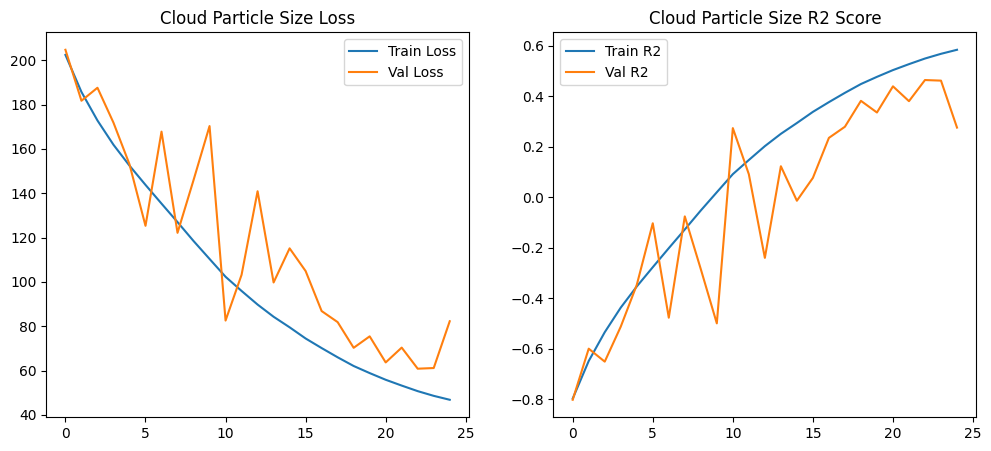

In [10]:
#PLOT LOSS and ACCURACY

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Cloud Particle Size Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train R2')
plt.plot(val_accuracies, label='Val R2')
plt.title('Cloud Particle Size R2 Score')
plt.legend()

plt.savefig("./graphs/unet_cps.png")  

plt.show()

In [11]:
#MODEL EVALUATION

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        outputs = model(inputs)

        all_preds.append(outputs.cpu().numpy().reshape(-1))
        all_labels.append(labels.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:00<00:00, 17.51it/s]


r2: 0.2689509987831116
MSE: 79.64493560791016
